<a href="https://colab.research.google.com/github/simulate111/Computer-Vision-and-Sensor-Fusion/blob/main/Assignment4_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 4: TKO_7096-3001 Computer Vision and Sensor Fusion


Goal: develop a RGB-Depth fusion architecture for semantic segmentation based on Fully Convolutional Network (FCN) .


<font color='red'> Deadline: 25.03.2024 at 24:00.

- Imports go here

### Load the dataset and Ground-truth###

- Dataset consists of 1100 (per modality) images of road scenes. It is divided into train (600 images), test (200 images) and validation (300 images) datasets.
- Change the size of all images into 256*256.
- Converting the labels into one hot encoding
- Create a DataLoader for loading the files when training the model.

In [ ]:
class DataLoader(Sequence):
    def __init__():
        #### Your Code
    def __len__(self):
        #### Your Code
    def __getitem__():
        #### Your Code
    def __generate_data(self, batch_rgb_files, batch_depth_files, batch_label_files):
        #### Your Code

- Visualize the data you have prepared

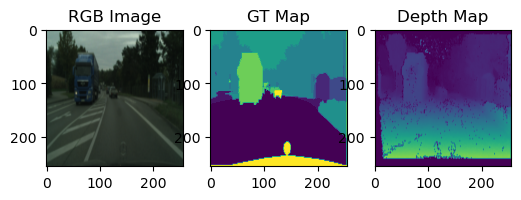

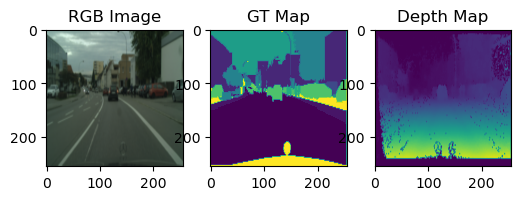

 Define a Fully Convolutional Network (FCN) for image segmentaion by fusing RGB and depth images. The network consists of  two sterams which each stream has following layers:

    1. Use the pretrained ResNet50 on imageNet
    2. Add two Conv layers with 128 and 256 nodes, respectively. Kernel size (3,3), stride (1,1)
    3. Top of the Conv layers, add dropout layer with 0.2
    4. Concatenate two streams.
    5. Add a transposed convolution layer (Conv2DTranspose)  with Kernel size (64,64), stride (32,32)
    6. Add a softmax activation layer
    
 You can find the model summary and structure in the PDF file.


Compile the model with SGD(learning_rate=0.01, decay=1e-5, momentum=0.9) and loss="categorical_crossentropy"

Train the model on the “train” dataset  and “validation”dataset for epochs =10.

 Evaluate the model on the training and test dataset. The results must be shown as

- Print loss and accuracy of model for  test dataset.

- Predict semantically segmented images on 5 random example of test dataset.

- Visualize the 5 random examples alongside the ground truth and prediction.

50/50 - 27s - loss: 0.9340 - accuracy: 0.7286 - 27s/epoch - 547ms/step
Test loss: 0.934032678604126
Test accuracy: 0.728630781173706


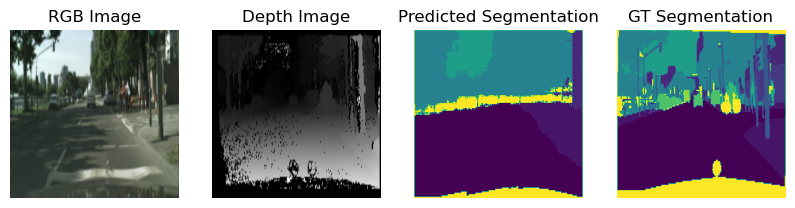

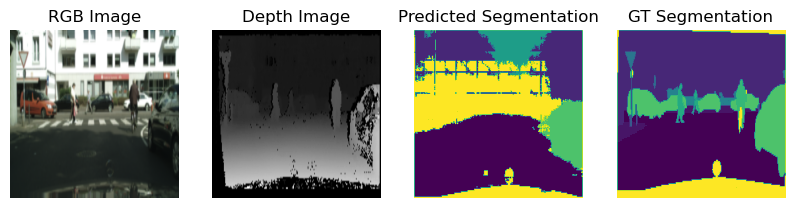

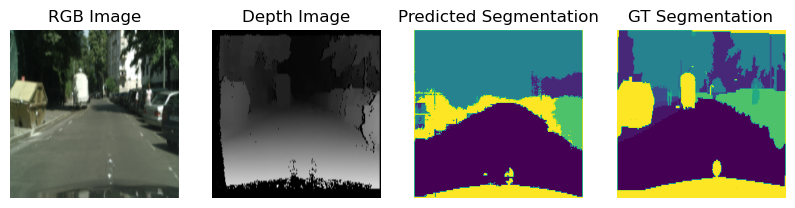

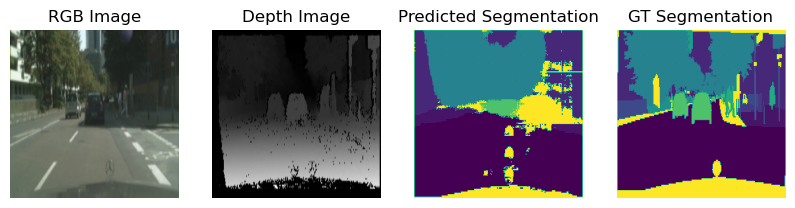

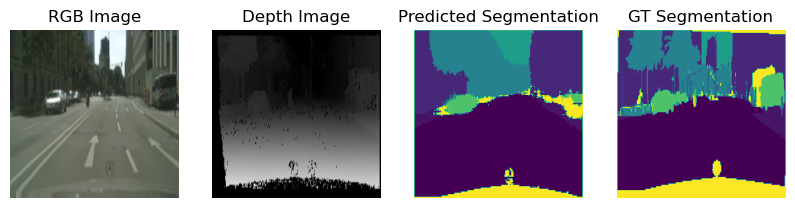

### Extra 5 points :

Implement FCNs for each sing modality and compare their accuracy with fusion model. I need the result of the following table in the same notebook.

# RESULT

| **Modality** | **Test Accuracy(%)** |
| -------- | -------- |
| RGB only |  |
| Depth Only |  |
| RBB and Depth Fusion |  |